# CART methods and Random Forests on Chessboard Pattern
In this notebook we examine CART models with fixed depth, or fixed number of leaves, along with random forest models. The data we work with will be a $6\times 6$ cornflowerblue-orange chessboard. 

But first a simple test:

## Visualizing the accuracy, gini and entropy criteria
However, befor doing so, let us visualize a one-dimensional data set where the optimal separating line is going to be placed using either accurcy, or entropy or the Gini Index as the discriminator. The two dimesional data is generated randomly and uniformly in a range. Only the $x$ axis is relevant and the $y$ axisis is uswd for better visualiation. 

We assign the colors red and blue to the points govened by the following rule: Each point is assigned the color red by probability $\tfrac{N}{\alpha r}$ where $N$ is the number of data points and $r$ is the rank of the point in the list of points according to hte $x$ coordiante (from smallest to largest.) Therefore, the points far to the left tend to be red, and the points far to right tend to be blue and as we move to the middle the colors are essentiall random. The $\alpha$ parameter control where the transition from red to blue takes place. For example, for $\alpha=1$ the mid point of the data will be red or blue ith equal likelihood.

In [2]:
import numpy as np

def optDisc (x, d, c, L=0, R=2): 
    """
    x: a real numner between L and R
    d: a vector of distinct real numbers between L and R
    c: a vector of k categorical values (e.g. colors)
    returns the entropy of the set of colors < x plus the entropy of the set of colors >= x
    """
    from collections import Counter
    import matplotlib.pyplot as plt
    
    if len(d)==0: return 0.0

    if len(d) != len(c):
        Exception(f"lengths of c and d should be equal, but len(c)={len(c)}, and len(d)={len(d)}")
        return None
    
    d1=[d[i] for i in range(len(d)) if d[i]<x ]
    d2=[d[i] for i in range(len(d)) if d[i]>=x ]
    c1=[c[i] for i in range(len(c)) if d[i]<x]
    c2=[c[i] for i in range(len(c)) if d[i]>=x]

    #classes=Counter(c).keys()
    #vals=Counter(c).values()
    #p=[y/sum(list(vals)) for y in list(vals)]
    classes1=Counter(c1).keys()
    vals1=Counter(c1).values()
    p1=[y/sum(list(vals1)) for y in list(vals1)]
    classes2=Counter(c2).keys()
    vals2=Counter(c2).values()
    p2=[y/sum(list(vals2)) for y in list(vals2)]
    N1=len(d1)
    N2=len(d2)
    N=len(d)

    ent1=-np.sum(np.array(p1)*np.log(np.array(p1)))
    ent2=-np.sum(np.array(p2)*np.log(np.array(p2)))
    gini1=np.sum(np.array(p1)*(1-np.array(p1)))
    gini2=np.sum(np.array(p2)*(1-np.array(p2)))
    acc1=1-max(p1)
    acc2=1-max(p2)

    return([(ent1*N1+ent2*N2)/N,(gini1*N1+gini2*N2)/N,(acc1*N1+acc2*N2)/N,p1,p2])

## Plot of the accuracy, entropy and the Gini Index with respect to $x$
The minimum points of each these curves are the optimal place for placing the splitting according tho the curves criterion.

In [5]:
import matplotlib.pyplot as plt

#d=[0.3,0.4,0.7,0.8,0.9,1.1,1.5]
#c=['b','g','r','b','g','r','g']
N=500
d=list(np.sort(np.random.uniform(0,1.9,N)))
#c=['b']*2+['r']+['b']*3+['r']*3+['b']+['r']*5
#c=['b']*7+['r']*8
c=['r' if np.random.uniform(1,N+1,1)/(2*i) > 1 else 'b' for i in range(1,N+1) ]
L=0 #min(d+[0.0])
R=2 #max(d+[1.])
dd=[(d[i+1]+d[i])/2. for i in range(len(d)-1)] #midpoints of data

ffent=lambda x: [optDisc(x,d,c,L=L,R=R)[0] for x in dd]
ffgini=lambda x: [optDisc(x,d,c,L=L,R=R)[1] for x in dd]
ffacc=lambda x: [optDisc(x,d,c,L=L,R=R)[2] for x in dd]

We now plot the accuracy, gini and entropy curves on this data:

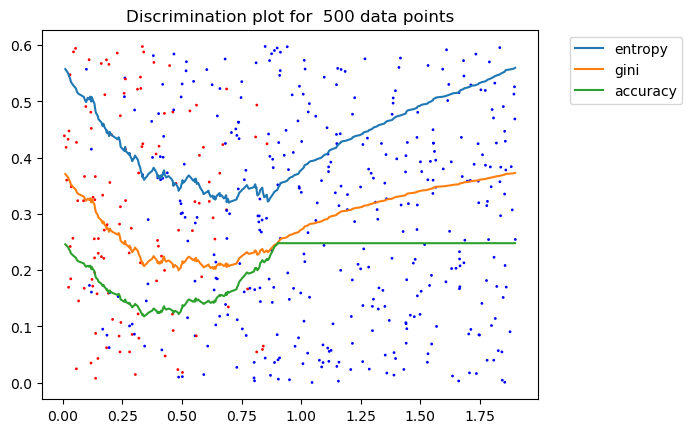

In [8]:
plt.plot(dd, ffent(dd),label="entropy")
plt.plot(dd,ffgini(dd),label="gini")
plt.plot(dd,ffacc(dd),label="accuracy")
plt.scatter(d, np.random.uniform(0,.6,len(d)),s=1,color=c)
plt.title(f"Discrimination plot for  {N} data points")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [10]:
optDisc(1,d,c,L,R)

[0.37737378580173664,
 0.27153284671532846,
 0.248,
 [0.45255474452554745, 0.5474452554744526],
 [1.0]]

# The chessboard recognition problem

## First plot the true boundries classes defined by $f(x,y)$:

In [14]:
def plotTrueBoundaries(f):
    """
    Plot the true bounaries and colors of classes
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import pandas as pd
    from scipy import stats
    from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
    
    #The function whose positive and negative values determine the chessboard patter:
    
    # Generate points to plot the countour of level 0 for the real f(x,y):
    x,y=np.linspace(-3,3,100),np.linspace(-3,3,100)
    
    #Set up the two-dimensional grid
    X,Y=np.meshgrid(x,y)
    Z=f(X,Y)
    
    # Plot the true boundaries, and the scatter plot of the data with true colors
    
    plt.contourf(X,Y,Z, levels=0,colors=["orange","cornflowerblue"])
    plt.title("The true boundaries")
    plt.show()

## Function for generating the training data

Draw a sample for training. The sample could be noiseless or noisy with a normal displacement:

In [17]:
def genData(f,N=1000,randErr=False,sigma=0.2):
    """
    Generate N sample points, determine their colors and return the result in X, y
    X: N x 2 matrix containing the two coordinates of the set of points
    y: N x 1 vector indicting color of each point
    """
    if N==0: return

    X=np.zeros((N,2))
    X[:,0]=np.random.uniform(-3,3,N)
    X[:,1]=np.random.uniform(-3,3,N)
    y=['cornflowerblue' if f(X[i,0],X[i,1])>0 else 'orange' for i in range(N)]

    # If you want to introduce some error, comment out the line above and
    # uncommnet  the line below

    if randErr:
        y=['cornflowerblue' if f(X[i,0]+np.random.normal(0,sigma),X[i,1]+np.random.normal(0,sigma))>0\
            else 'orange' for i in range(N)]

    #Plot the data with their correct colors and the correct boundary:
    XX,YY=np.meshgrid(np.linspace(-3,3,100),np.linspace(-3,3,100))
    ZZ=f(XX,YY)
    plt.contour(XX,YY,ZZ, levels=0)
    plt.scatter([X[i,0] for i in range(N) if y[i]=='cornflowerblue'],\
                [X[i,1] for i in range(N) if y[i]=="cornflowerblue"],
                color="cornflowerblue",s=2)
    plt.scatter([X[i,0] for i in range(N) if y[i]=='orange'],\
                [X[i,1] for i in range(N) if y[i]=="orange"],
                color="orange",s=2)
    plt.title("colors in the training data")
    plt.show()
    return X,y


## Generate grid data

The gird data is equally spaced data used for testing the algorithms

In [21]:
def genGridDF(xLow, xHigh, xN, yLow, yHigh, yN, xTitle="xNew", yTitle="yNew"):
    """
    This function genrates an xN x yN two-dimensional grid. The x
    range is between xLow and xHigh, and the y range bwtween yLow and yHigh
    It returns the flattenned matrix of the grid.
    """
    import numpy as np
    import pandas as pd

    x1=np.linspace(xLow,xHigh,xN)
    x2=np.linspace(yLow, yHigh,yN)
    
    X=np.zeros((xN*yN,2))
    X[:,0]=np.kron(x1,np.ones(len(x2)))
    X[:,1]=np.kron(np.ones(len(x1)),x2)
   
    return X

# Build the CART model:
## Fixed Tree:

In [24]:
def BuildTreeAndRun(X,y,max_depth=15):
    from sklearn.model_selection import train_test_split
    import matplotlib.pyplot as plt
    from sklearn.metrics import classification_report, confusion_matrix
    import seaborn as sns
    #import scipy as sp
    import numpy as np
    
    from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
    
    tree=DecisionTreeClassifier(max_depth=max_depth)
    treeModel=tree.fit(X, y)
    #pred=lambda x1,x2: treeModel.predict_proba(np.array([x1,x2]).reshape(1,-1))
    
    xx,yy=np.linspace(-3,3,101),np.linspace(-3,3,101)
    GX,GY=np.meshgrid(xx,yy)
    GZ=treeModel.predict_proba(genGridDF(-3,3,101,-3,3,101))[:,0].reshape(len(xx),len(yy),order='F')
    plt.contour(GX,GY,GZ, levels=[0.5],colors=["teal"])
    
    from matplotlib.colors import ListedColormap, LinearSegmentedColormap
    #colors=["orange","cornflowerblue"]
    colors=list(set(y))
    #cmp = ListedColormap(["orange","goldenrod","gold","yellow", "yellowgreen",\
    #                      "cyan","lightgreen","chartreuse","aqua", "azure","lightcornflowerblue","cornflowercornflowerblue", "cornflowerblue"])
    cmp=LinearSegmentedColormap.from_list("mycmap", colors)
    #plt.imshow(GZ[range(GZ.shape[0]-1,0,-1),:], cmap="plasma",\
    #       extent=(-3,3,-3,3))
    plt.imshow(GZ[range(GZ.shape[0]-1,0,-1),:], cmap=cmp,\
            extent=(-3,3,-3,3))   
    plt.colorbar()
    plt.title(f"the probability distribution of predicted colors with single CART deth={depth}")
    plt.show()
    
    plt.contour(GX,GY,GZ, levels=[0.5],colors="teal")
    XG=genGridDF(-3,3,100,-3,3,100)
    cartPred=treeModel.predict(XG)
    realCol=['cornflowerblue' if f(XG[i,0],XG[i,1])>0 else 'orange' for i in range(XG.shape[0])]
    plt.scatter(XG[:,0], XG[:,1], s=1, color=cartPred)
    plt.title(f"The predicted colors on a single CART of depth {max_depth}")
    plt.show()
    print(f"Confusion matrix for CART model with depth {depth}:\n{confusion_matrix(realCol,cartPred)}")
    print(f"Classification Report for CART model with depth {depth}:\n{classification_report(realCol,cartPred)}")    

# Random Forest Algorithm

In [36]:
#def buildRFandRun(X,y,n_estimators=500,max_leaf_nodes=16):
def buildRFandRun(X,y,n_estimators=500,max_depth=15):


    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

    #rf=RandomForestClassifier(n_estimators=n_estimators,max_leaf_nodes=max_leaf_nodes,n_jobs=-1)
    rf=RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,n_jobs=-1)

    rfModel=rf.fit(X, y)
    
    xx,yy=np.linspace(-3,3,101),np.linspace(-3,3,101)
    GX,GY=np.meshgrid(xx,yy)
    GZ=rf.predict_proba(genGridDF(-3,3,101,-3,3,101))[:,0].reshape(len(xx),len(yy),order='F')
    plt.contour(GX,GY,GZ, levels=[0.5],colors=["teal"])
    
    from matplotlib.colors import ListedColormap, LinearSegmentedColormap
    #colors=["orange","cornflowerblue"]
    colors=list(set(y))
    #cmp = ListedColormap(["orange","goldenrod","gold","yellow", "yellowgreen",\
    #                      "cyan","lightgreen","chartreuse","aqua", "azure","lightcornflowerblue","cornflowercornflowerblue", "cornflowerblue"])
    cmp=LinearSegmentedColormap.from_list("mycmap", colors)
    #plt.imshow(GZ[range(GZ.shape[0]-1,0,-1),:], cmap="plasma",\
    #       extent=(-3,3,-3,3))
    plt.imshow(GZ[range(GZ.shape[0]-1,0,-1),:], cmap=cmp,\
            extent=(-3,3,-3,3))   
    plt.colorbar()
    plt.title(f"Probability distribution of prediction for RF with depth {depth}")
    plt.show()
    
    plt.contour(GX,GY,GZ, levels=[0.5],colors="teal")
    XG=genGridDF(-3,3,100,-3,3,100)
    rfPred=rf.predict(XG)
    realCol=['cornflowerblue' if f(XG[i,0],XG[i,1])>0 else 'orange' for i in range(XG.shape[0])]
    plt.scatter(XG[:,0], XG[:,1], s=1, color=rfPred)
    plt.title(f"The predicted colors of the grid data with RF with depth {depth}")
    plt.show()
    
    print(f"Confusion matrix for RF model with depth {depth}:\n{confusion_matrix(realCol,rfPred)}")
    print(f"Classification Report for RF model with depth {depth}:\n{classification_report(realCol,rfPred)}")

## Test the algorithm on the data:

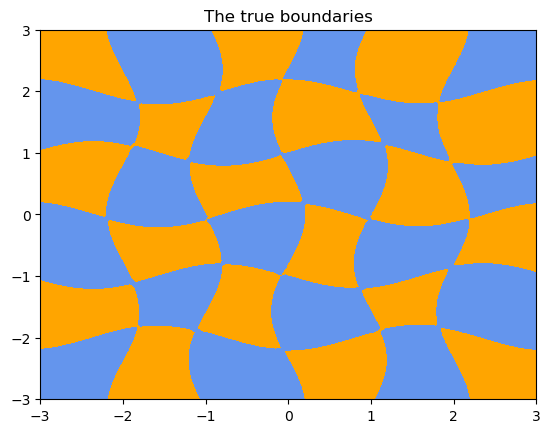

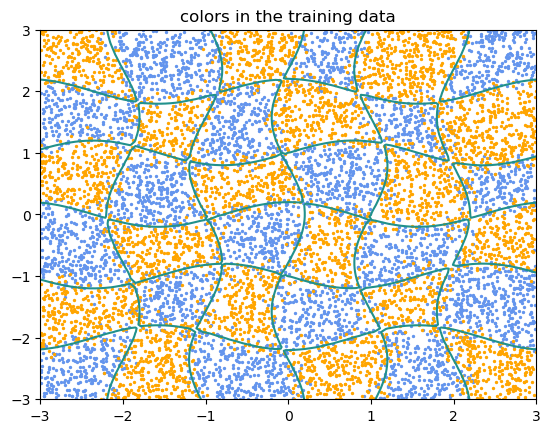

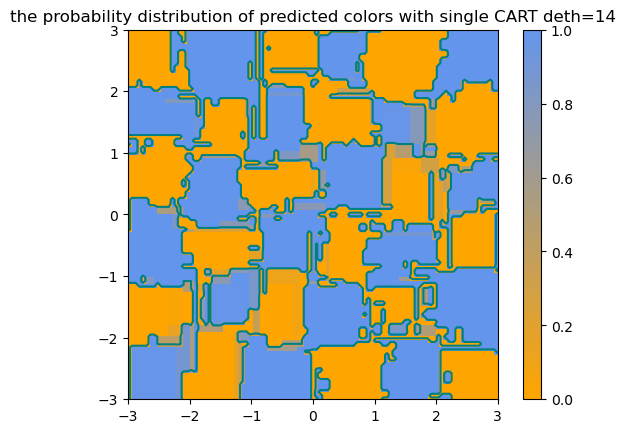

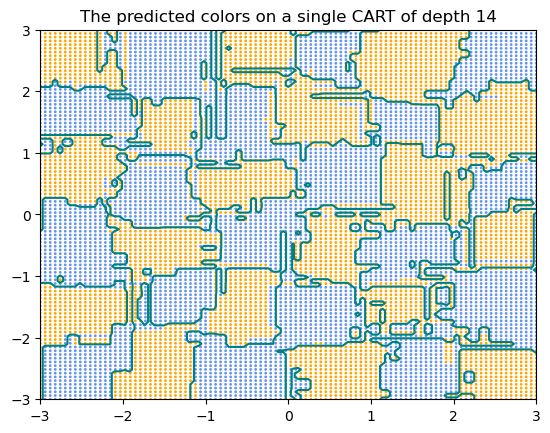

Confusion matrix for CART model with depth 14:
[[4481  613]
 [ 634 4272]]
Classification Report for CART model with depth 14:
                precision    recall  f1-score   support

cornflowerblue       0.88      0.88      0.88      5094
        orange       0.87      0.87      0.87      4906

      accuracy                           0.88     10000
     macro avg       0.88      0.88      0.88     10000
  weighted avg       0.88      0.88      0.88     10000



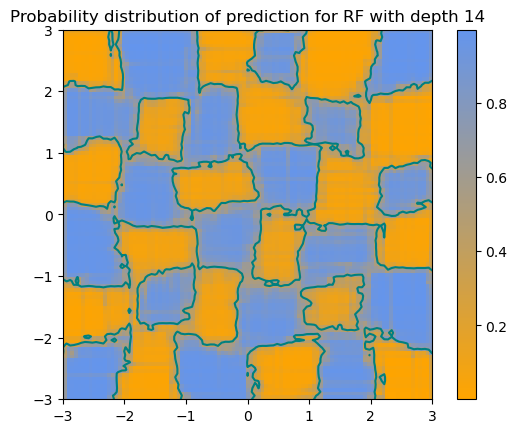

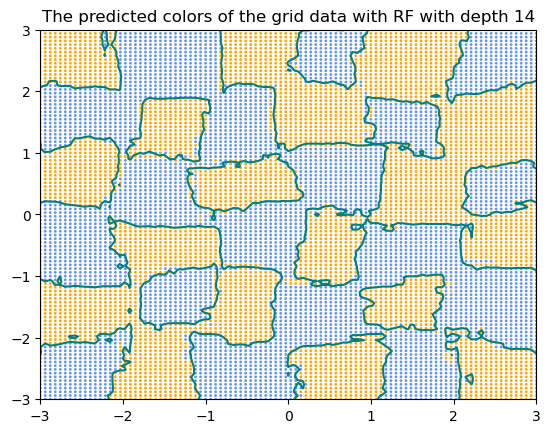

Confusion matrix for RF model with depth 14:
[[4657  437]
 [ 362 4544]]
Classification Report for RF model with depth 14:
                precision    recall  f1-score   support

cornflowerblue       0.93      0.91      0.92      5094
        orange       0.91      0.93      0.92      4906

      accuracy                           0.92     10000
     macro avg       0.92      0.92      0.92     10000
  weighted avg       0.92      0.92      0.92     10000



In [39]:
#f=lambda x, y: (x-2)*(x-1)*x*(x+1)*(x+2)*(y-2)*(y-1)*y*(y+1)*(y+2)
a=2.
f= lambda x,y: (y+2+0.2*np.cos(a*x))*(y+1+0.2*np.sin(a*x))*(y-0.2*np.cos(a*x))*(y-0.2*np.sin(a*x)-1)*(y-0.2*np.cos(a*x)-2)*\
               (x+2+0.2*np.cos(a*y))*(x+1+0.2*np.sin(a*y))*(x-0.2*np.cos(a*y))*(x-0.2*np.sin(a*y)-1)*(x-0.2*np.cos(a*y)-2)

plotTrueBoundaries(f)
depth=14

X,y=genData(f,N=10000,randErr=True,sigma=0.1)
BuildTreeAndRun(X,y,max_depth=depth)
buildRFandRun(X,y,max_depth=depth)

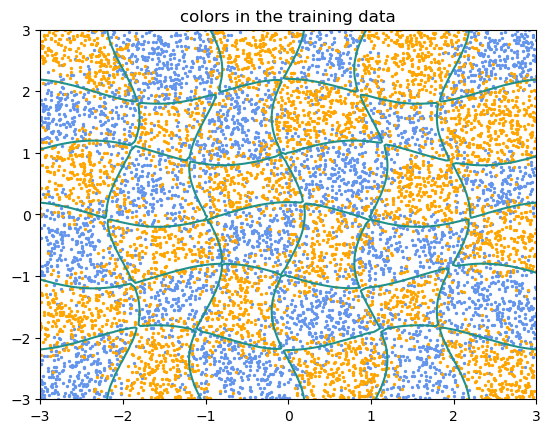

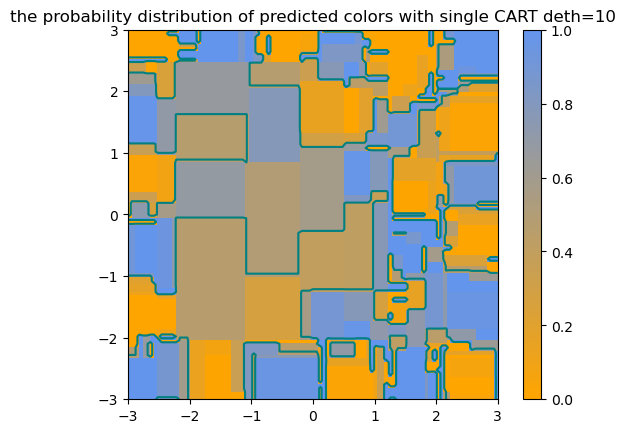

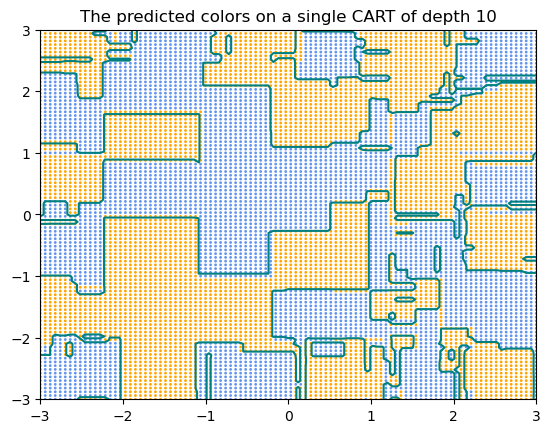

Confusion matrix for CART model with depth 10:
[[3946 1148]
 [ 942 3964]]
Classification Report for CART model with depth 10:
                precision    recall  f1-score   support

cornflowerblue       0.81      0.77      0.79      5094
        orange       0.78      0.81      0.79      4906

      accuracy                           0.79     10000
     macro avg       0.79      0.79      0.79     10000
  weighted avg       0.79      0.79      0.79     10000



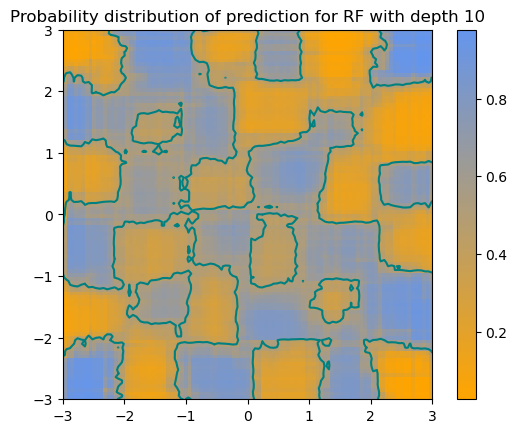

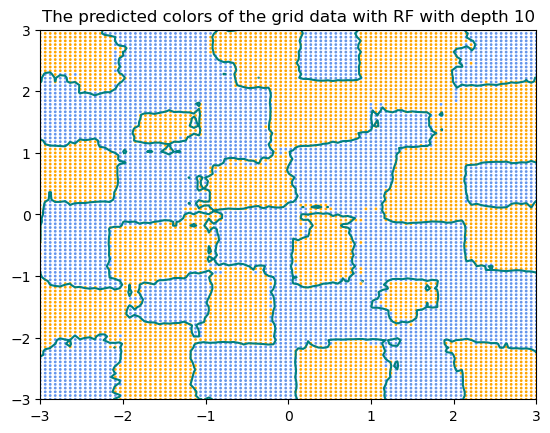

Confusion matrix for RF model with depth 10:
[[4596  498]
 [ 645 4261]]
Classification Report for RF model with depth 10:
                precision    recall  f1-score   support

cornflowerblue       0.88      0.90      0.89      5094
        orange       0.90      0.87      0.88      4906

      accuracy                           0.89     10000
     macro avg       0.89      0.89      0.89     10000
  weighted avg       0.89      0.89      0.89     10000



In [41]:
X,y=genData(f,N=10000,randErr=True, sigma=0.2)
depth=10
BuildTreeAndRun(X,y,max_depth=depth)
buildRFandRun(X,y,max_depth=depth)

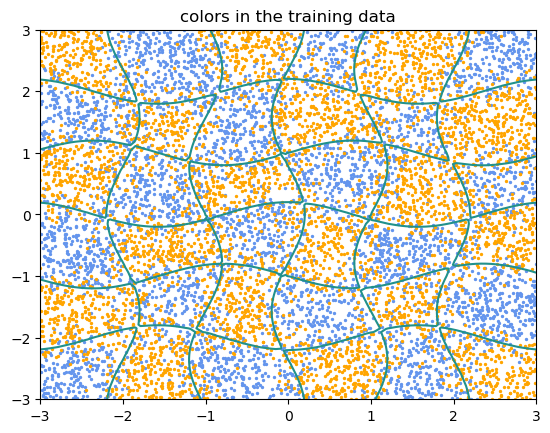

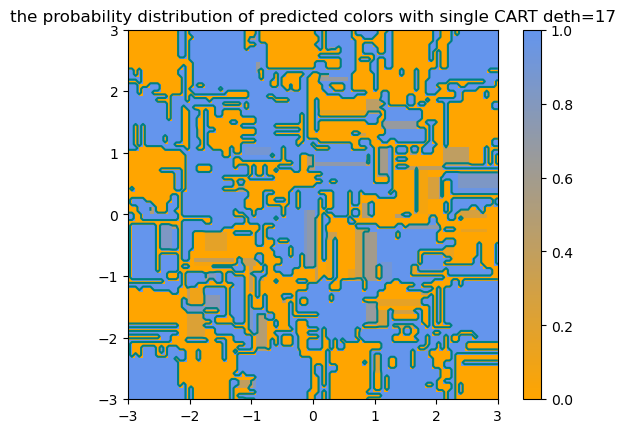

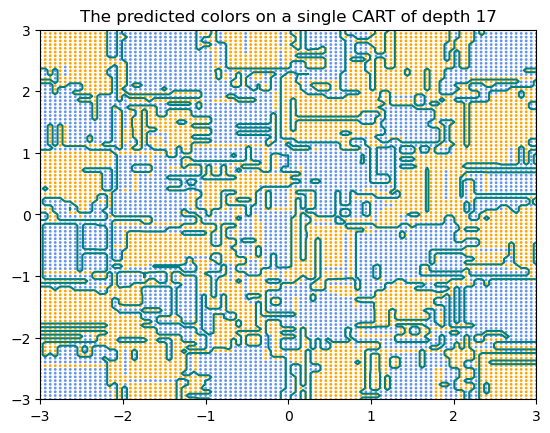

Confusion matrix for CART model with depth 17:
[[3967 1127]
 [1088 3818]]
Classification Report for CART model with depth 17:
                precision    recall  f1-score   support

cornflowerblue       0.78      0.78      0.78      5094
        orange       0.77      0.78      0.78      4906

      accuracy                           0.78     10000
     macro avg       0.78      0.78      0.78     10000
  weighted avg       0.78      0.78      0.78     10000



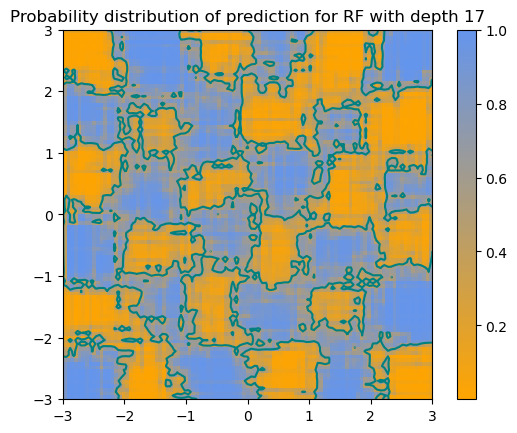

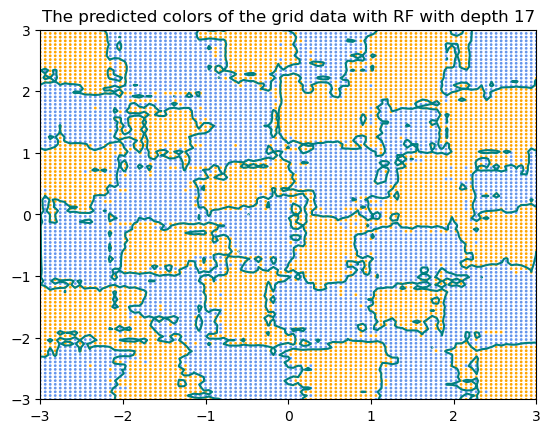

Confusion matrix for RF model with depth 17:
[[4422  672]
 [ 768 4138]]
Classification Report for RF model with depth 17:
                precision    recall  f1-score   support

cornflowerblue       0.85      0.87      0.86      5094
        orange       0.86      0.84      0.85      4906

      accuracy                           0.86     10000
     macro avg       0.86      0.86      0.86     10000
  weighted avg       0.86      0.86      0.86     10000



In [43]:
X,y=genData(f,N=10000, randErr=True, sigma=0.2)
depth=17
BuildTreeAndRun(X,y,max_depth=depth)
buildRFandRun(X,y,max_depth=depth)